<a href="https://colab.research.google.com/github/shlomi1993/deep-learning-notebooks/blob/main/7_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7 - Recurrent Neural Network

## Introduction

In this notebook, we explore the training and design of **recurrent neural networks (RNNs)** in two parts.

The first part focuses on implementing an RNN for sentence **sentiment classification** on the **[SST-2 dataset](https://huggingface.co/datasets/stanfordnlp/sst2)**, while addressing the **exploding gradient** problem by applying **truncated backpropagation through time (BPTT)**. This involves carefully controlling the flow of gradients through the recurrent layers and visualizing their behavior over time steps.

In the second part, we design a custom **RNN cell** with basic flow control. This cell includes a **"reset gate"** that enables the network to learn when to forget its hidden state based solely on the current input. The task involves designing the gating mechanism, selecting appropriate activation functions, and justifying the architectural decisions. We then train a network using this custom cell on a small dataset to demonstrate its ability to learn and overfit, validating the correctness of the implementation.

Throughout the task, we emphasize understanding the internal dynamics of RNNs, gradient flow over time, and architectural flexibility in designing custom recurrent units.

## Prerequisites

#### Install `torchtext` package

In [ ]:
# !pip install torchtext

**Note:** The very basic `pip install torchtext` command above didn't work for me. Although the installation completed successfully, trying to import the package resulted in the following error:

```
OSError: /usr/local/lib/python3.11/dist-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
```

This issue occurs due to incompatibilities caused by deprecations in TorchText.

After going back and forth with ChatGPT, I finally found a working solution: install TorchText version 0.18.0 along with the compatible PyTorch version 2.3.0.

Additionally, to avoid the error

```
ValueError: Invalid pattern: '**' can only be an entire path component
```

which occurs when using `load_dataset` from the `datasets` library, we need to install `fsspec` version 2023.6.0.

Therefore, we reinstall all three packages as follows:

In [ ]:
!pip uninstall -y torch torchtext fsspec  # Session restart maybe required after this line, then re-run notebook
!pip install torch==2.3.0 torchtext==0.18.0 fsspec==2023.6.0

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: fsspec 2025.3.2
Uninstalling fsspec-2025.3.2:
  Successfully uninstalled fsspec-2025.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 808.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 836.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

- Note that this solution might require restarting the session for the changes to take effect.

- After restarting the session with the updated packages, the installation step will be skipped, and the following code blocks will be executed successfully.

#### Import relevant Python packages

In [ ]:
# PyTorch core
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence  # For sequence padding

# Hugging Face datasets
import datasets as ds

# Data visualization
import matplotlib.pyplot as plt

# Progress bar for notebooks
from tqdm.notebook import tqdm

# TorchText vocabulary (import torchtext and suppress its deprecation warning)
import torchtext; torchtext.disable_torchtext_deprecation_warning()
from torchtext.vocab import build_vocab_from_iterator

## RNN for SST-2 Classification

We start with training an RNN-based classifier on the SST-2 (Stanford Sentiment Treebank 2) sentiment analysis dataset. A core challenge is to handle the exploding gradient problem, which is especially relevant when training RNNs over long sequences. To mitigate this, we'll implement truncated backpropagation through time (BPTT), limiting how far the gradient is allowed to propagate.

We walk through the following steps:

1. Preprocessing the SST-2 dataset.

2. Defining an appropriate RNN-based classifier

3. Implementing custom gradient clipping through time manually (instead of relying solely on PyTorch's autograd)

4. Saving hidden states and analyzing the effect of clipping on gradient flow.

### Load and Preprocess the SST-2 Dataset

We begin by loading the SST-2 dataset using the datasets library and processing the text into a numerical format suitable for neural networks. We'll tokenize each sentence, build a vocabulary, and convert the tokens to integer indices.

#### Load SST-2 dataset

Load the dataset:

In [ ]:
train_data = ds.load_dataset("glue", "sst2")["train"]
sentence_list = train_data["sentence"]
int_labels_list = train_data["label"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Explore the dataset

In [ ]:
for i, (sentence, int_label) in enumerate(zip(sentence_list[:10], int_labels_list[:10])):
    print(f"{i}: {sentence} --> {int_label} ({'Positive' if int_label else 'Negative'})")

0: hide new secretions from the parental units  --> 0 (Negative)
1: contains no wit , only labored gags  --> 0 (Negative)
2: that loves its characters and communicates something rather beautiful about human nature  --> 1 (Positive)
3: remains utterly satisfied to remain the same throughout  --> 0 (Negative)
4: on the worst revenge-of-the-nerds clichés the filmmakers could dredge up  --> 0 (Negative)
5: that 's far too tragic to merit such superficial treatment  --> 0 (Negative)
6: demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop .  --> 1 (Positive)
7: of saucy  --> 1 (Positive)
8: a depressed fifteen-year-old 's suicidal poetry  --> 0 (Negative)
9: are more deeply thought through than in most ` right-thinking ' films  --> 1 (Positive)


#### Tokenize

In [ ]:
tokenizer = lambda x: x.split()
tokenized = list(map(tokenizer, sentence_list))

for i, token_list in enumerate(tokenized[:10]):
    print(f"{i}: {token_list}")

0: ['hide', 'new', 'secretions', 'from', 'the', 'parental', 'units']
1: ['contains', 'no', 'wit', ',', 'only', 'labored', 'gags']
2: ['that', 'loves', 'its', 'characters', 'and', 'communicates', 'something', 'rather', 'beautiful', 'about', 'human', 'nature']
3: ['remains', 'utterly', 'satisfied', 'to', 'remain', 'the', 'same', 'throughout']
4: ['on', 'the', 'worst', 'revenge-of-the-nerds', 'clichés', 'the', 'filmmakers', 'could', 'dredge', 'up']
5: ['that', "'s", 'far', 'too', 'tragic', 'to', 'merit', 'such', 'superficial', 'treatment']
6: ['demonstrates', 'that', 'the', 'director', 'of', 'such', 'hollywood', 'blockbusters', 'as', 'patriot', 'games', 'can', 'still', 'turn', 'out', 'a', 'small', ',', 'personal', 'film', 'with', 'an', 'emotional', 'wallop', '.']
7: ['of', 'saucy']
8: ['a', 'depressed', 'fifteen-year-old', "'s", 'suicidal', 'poetry']
9: ['are', 'more', 'deeply', 'thought', 'through', 'than', 'in', 'most', '`', 'right-thinking', "'", 'films']


- Use simple whitespace splitting for tokenization.

- Simple whitespace splitting tokenizes text quickly and efficiently without extra dependencies, making it ideal for clean, well-formatted data. It is a straightforward method that works well for many basic NLP tasks.

#### Build vocabulary

In [ ]:
vocab = build_vocab_from_iterator(tokenized, specials=["<UNK>"], min_freq=5)
vocab.set_default_index(vocab["<UNK>"])

for i, token in enumerate(vocab.get_itos()[:10]):
    print(f"{i}: {token}")

0: <UNK>
1: the
2: ,
3: a
4: and
5: of
6: .
7: to
8: 's
9: is


- Setting the minimum frequency to 5 (`min_freq=5`) means that only tokens appearing at least 5 times in the dataset will be included in the vocabulary. This helps reduce vocabulary size by filtering out rare words, which can improve model efficiency and generalization.

- The `specials=["<UNK>"]` argument adds a special token `<UNK>` to the vocabulary, which is used to represent any word that is not found in the vocabulary (i.e., rare or unseen words). This ensures the model can handle unknown tokens gracefully during inference.

#### Map tokenized sentences to integers

In [ ]:
stoi = lambda x: torch.tensor(vocab(x), dtype=torch.long)
integer_tokens = list(map(stoi, tokenized))
labels = list(map(torch.tensor, int_labels_list))

for i, (tokenized_sentence, int_label) in enumerate(zip(integer_tokens[:10], labels[:10])):
    print(f"{i}: {tokenized_sentence} --> {int_label} ({'Positive' if int_label else 'Negative'})")

0: tensor([ 4575,    93,     0,    36,     1,  7746, 10013]) --> 0 (Negative)
1: tensor([2924,   61,  330,    2,   89, 1993,  549]) --> 0 (Negative)
2: tensor([  10, 1792,   17,   54,    4, 6088,   96,  186,  265,   34,  178,  627]) --> 1 (Positive)
3: tensor([ 594,  682, 6402,    7, 2008,    1,  290,  704]) --> 0 (Negative)
4: tensor([  24,    1,  255, 5415,  552,    1,  358,  117, 4856,   53]) --> 0 (Negative)
5: tensor([  10,    8,  173,   50,  783,    7, 1841,  121,  954, 1038]) --> 0 (Negative)
6: tensor([2719,   10,    1,  108,    5,  121,  163, 3470,   13, 7012, 1446,   65,
         151,  417,   49,    3,  397,    2,  531,   16,   14,   15,  207, 3148,
           6]) --> 1 (Positive)
7: tensor([   5, 7101]) --> 1 (Positive)
8: tensor([   3, 3844, 7500,    8, 7924,  857]) --> 0 (Negative)
9: tensor([  37,   27,  334,  782,  100,   31,   11,   43,   67, 7082,   45,  118]) --> 1 (Positive)


- This way we convert tokens into integer IDs using the vocabulary and then into PyTorch tensors, making the data ready for model input. It is an efficient way to transform text and labels into numeric format for training.

#### Section summary

After this step, we have a list of tokenized sentences represented as integer tensors, and corresponding label tensors. These will serve as inputs to our RNN model.

### Define an RNN Model with Truncated BPTT for SST-2 Classification

Next, we define a simple RNN-based model for sentiment classification task on the SST-2 dataset.

The task is to classify whether a given sentence expresses a positive or negative sentiment. Since SST-2 is a binary classification dataset, we design a model that processes a variable-length sequence of word embeddings using an RNN, and then classifies the sentence based on the final hidden state.

We implement the model using PyTorch's RNN module (`nn.RNN`), combined with an embedding layer (`nn.Embedding`) and a fully connected (`nn.Linear`) output layer.

To address the exploding gradient problem common in training RNNs on long sequences, we implement truncated backpropagation through time (BPTT) within the model's forward method. This is done by detaching the hidden state every $t$ tokens, which limits the gradient flow to the last $t$ steps and stabilizes training.

Additionally, to enable gradient monitoring (for section **1.d**), the model supports an optional `retain_grad` flag in the forward method. When enabled, it allows intermediate hidden states to retain gradients, which can be used for visualizing and analyzing the gradient flow through time. This is particularly useful for understanding how well the model is able to propagate information across time steps and for debugging vanishing/exploding gradient issues.

In [ ]:
class RNNClassifier(nn.Module):
    """
    An RNN-based model with truncated backpropagation through time (BPTT) for binary sentiment classification.

    The model includes an embedding layer, an RNN layer, and a final linear classifier. During the forward pass,
    truncated BPTT is implemented by detaching the hidden state every `t` time steps, which limits how far gradients
    can flow backward in time.
    """

    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, output_dim: int = 2) -> None:
        """
        Initialize the RNNClassifier.

        Args:
            vocab_size (int): Size of the vocabulary.
            embedding_dim (int): Dimensionality of word embeddings.
            hidden_dim (int): Number of hidden units in the RNN.
            output_dim (int): Number of output classes (default is 2 for binary classification).
        """
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: Tensor, t: int, h_0: Tensor = None, monitor_grad: bool = False) -> tuple[Tensor, list[Tensor] | None]:
        """
        Forward pass that support truncated BPTT, and returns intermediate hidden states for gradient monitoring.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len) containing token indices.
            t (int): Truncation length - the number of time steps after which the hidden state is detached.
            h_0 (Tensor, optional): Initial hidden state. Defaults to None, which initialize zeros.
            monitor_grad (bool, optional): If True, retains gradients of hidden states and returns them. Defaults to False.

        Returns:
            Tensor: Output logits from final hidden state.
            list[Tensor] | None: List of hidden states with retained gradients if monitor_grad is True, else None.
        """
        batch_size, seq_len = x.size()
        assert batch_size == 1, "Only batch size 1 supported for truncated BPTT"

        # Initialize a list to store hidden states if monitor_grad is True
        if monitor_grad:
            hidden_states = []

        # Initialize the hidden state for the RNN
        h_t = h_0 or torch.zeros(1, batch_size, self.rnn.hidden_size, device=x.device)

        # Process the input sequence token-by-token
        for i in range(seq_len):
            token = x[:, i].unsqueeze(1)            # Extract the current token and add a time dimension
            embedded = self.embedding(token)        # Convert token index to embedding vector
            output, h_t = self.rnn(embedded, h_t)   # Pass the embedded token and previous hidden state through the RNN

            # Save hidden state with retained gradient for gradient monitoring and visualization
            if monitor_grad:
                h_t.retain_grad()
                hidden_states.append(h_t)

            # Detach hidden state every t steps to truncate gradient
            if (i + 1) % t == 0:
                h_t = h_t.detach()

        # Remove the first dimension from the hidden state
        final_hidden = h_t.squeeze(0)

        # Pass the final hidden state through the fully connected layer to get logits
        logits = self.fc(final_hidden)

        # Return the logits, i.e., the forward pass output, and a list if monitored hidded states or None
        return (logits, hidden_states) if monitor_grad else (logits, None)

**Design Notes:**

- The model is designed for binary sentiment classification using a simple RNN-based architecture.

- Sentences are represented by the final hidden state of the RNN, a common technique in sequence classification tasks.

- The input passes through an embedding layer, followed by an RNN layer and a final linear classifier.

- The RNN uses `batch_first=True`, so inputs are shaped as `(batch_size, seq_len)`, which is more intuitive to handle.

- To address exploding gradients, the model supports truncated backpropagation through time (BPTT) by detaching the hidden state every $t$ time steps during the forward pass.

- The forward method operates token-by-token and currently supports only `batch_size=1` for simplicity.

- The initial hidden state (`h_0`) defaults to `None`, letting PyTorch automatically use zero-initialized tensors.

- The model optionally supports gradient monitoring by retaining gradients on intermediate hidden states during the forward pass, which enables visualization and analysis of gradient flow across time steps.

### Monitor and Visualize Gradient Flow in Truncated BPTT

In this section, we aim to observe and demonstrate that the gradient of the loss with respect to the hidden states does not propagate beyond $t$ time steps, as expected when using truncated backpropagation through time (BPTT).

We'll do this by:

- Saving the hidden states during the forward pass (implemented already in the previous sections).

- Training the model on a few sample sentences.

- Monitoring the gradient norms of those hidden states.

- Plotting the gradient norms as a function of time steps.

This will confirm that the gradients "stop" at intervals of length $t$.

#### Prepare a small subset of data for visualization

To keep things manageable and interpretable, we'll use only a few short sentences for this analysis.

In [ ]:
n_samples = 10
sample_sentences = integer_tokens[:n_samples]
sample_labels = labels[:n_samples]

#### Define training components

Set hyperparameters

In [ ]:
embedding_dim = 32
hidden_dim = 64
learning_rate = 0.01
t_truncate = 7  # Truncation step

- We choose a small model for speed and interpretability.

- While we could experiment with different values for `embedding_dim`, `hidden_dim`, and `learning_rate`, the specific choices don't matter here since we're not optimizing for performance in this question. Our goal is to visualize how gradient sizes change as a function of the number of iterations.

- The setting of `t_truncate = 7` will control the maximum gradient flow length.

Print sentence lengths to verify $T > t$ for at least some samples

In [ ]:
[s.size(0) for s in sample_sentences]

[7, 7, 12, 8, 10, 10, 25, 2, 6, 12]

It is evident that some of the input sequences are longer than the truncation length `t_truncate` which set to `7`, so the effects of truncation will be observable.

Instantiate a model

In [ ]:
model = RNNClassifier(len(vocab), embedding_dim, hidden_dim)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Run a training step to collect gradient norms

Perform a single training step on each sentence and record the gradient norm of each hidden state.

In [ ]:
gradient_norms_per_sentence = []

model.train()
for sentence, int_label in zip(sample_sentences, sample_labels):
    x = sentence.unsqueeze(0)
    y = int_label.unsqueeze(0)

    optimizer.zero_grad()

    # Forward pass with gradient monitoring enabled
    logits, hidden_states = model(x, t=t_truncate, monitor_grad=True)

    # Loss calculation and backward pass
    loss = loss_func(logits, y)
    loss.backward()

    # Record gradient norm at each time step
    grad_norms = [h.grad.norm().item() if h.grad is not None else 0.0 for h in hidden_states]
    gradient_norms_per_sentence.append(grad_norms)

    # Optimize
    optimizer.step()

Each `hidden_state.grad` is recorded only if it exists (i.e., not `None`). If `h.grad` is `None`, it means no gradient reached that state, likely due to truncation, so we store `0.0`.

#### Visualize gradient norms

Now, we plot the gradient norms for each token position across all 5 sample sentences.

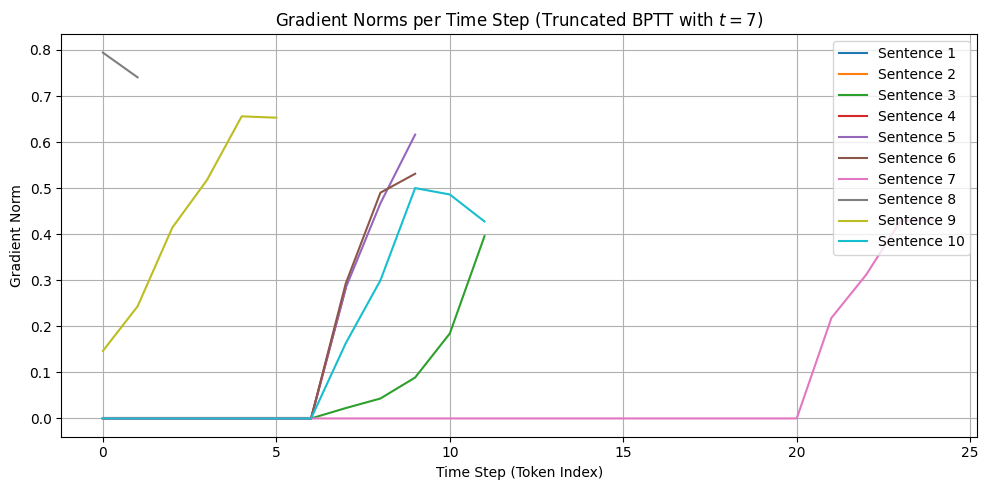

In [ ]:
plt.figure(figsize=(10, 5))

for i, grad_norms in enumerate(gradient_norms_per_sentence):
    plt.plot(grad_norms, label=f"Sentence {i+1}")

plt.xlabel("Time Step (Token Index)")
plt.ylabel("Gradient Norm")
plt.title(f"Gradient Norms per Time Step (Truncated BPTT with $t={t_truncate}$)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This plot shows the magnitude of gradients for each hidden state as a function of its position in the sentence. One can observe a repeating pattern, where the gradient "resets" every $t$ steps (e.g., spikes followed by zeros), confirming that gradients are not propagated beyond $t$ time steps.

#### Conclusion

By visualizing the gradient norms, we've demonstrated that truncated BPTT prevents gradient propagation beyond $t$ steps. This method mitigates the exploding (or vanishing) gradient problem by limiting how much temporal context the model considers during each backward pass.

## RNN Cell with Reset Gate

In this part, we implement a custom RNN cell that includes a reset gate dependent only on the current input token $x_t$.

The reset gate allows the network to selectively forget parts of the hidden state based only on the input at the current timestep, without considering the previous hidden state.

The reset gate is computed by passing the input through a linear transformation followed by a sigmoid activation. This gate is then applied element-wise to the candidate hidden state, which is calculated in the typical Elman RNN manner using both the input and the previous hidden state.

The resulting hidden state is the gated candidate state, allowing the model to "reset" or preserve information dynamically depending on the input.

This design can help the model learn to ignore or reset hidden information when certain inputs appear, which might be useful for detecting boundaries or specific tokens in sequences.

### Reset RNN Cell Class Definition

In [ ]:
class ResetRNNCell(nn.Module):
    """
    A custom RNN cell with a reset gate that depends only on the current input token.

    Unlike traditional gated RNN cells that use previous hidden states in gating, this cell computes the reset gate R_t
    using only the current input x_t. This allows the model to selectively reset or suppress parts of the candidate
    hidden state based on the current input alone, potentially improving handling of token-specific resets.
    """
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        """
        Initialize the ResetRNNCell.

        Args:
            input_dim (int): Dimension of the input vector x_t.
            hidden_dim (int): Dimension of the hidden state h_t.
        """
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.W_ih = nn.Linear(input_dim, hidden_dim, bias=True)
        self.W_hh = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.W_r = nn.Linear(input_dim, hidden_dim, bias=True)  # Reset gate linear layer (input only)

    def forward(self, x_t: Tensor, h_prev: Tensor) -> Tensor:
        """
        Perform a single time step update using tanh and sigmoid functions, followed by h_hat_t * R_t multiplication.

        Args:
            x_t (Tensor): Input at time t.
            h_prev (Tensor): Previous hidden state.

        Returns:
            Tensor: A new hidden state.
        """
        # Candidate hidden state combining current input and previous hidden state
        h_hat_t = torch.tanh(self.W_ih(x_t) + self.W_hh(h_prev))

        # Reset gate calculated only by current input to control how much of h_hat_t to keep
        R_t = torch.sigmoid(self.W_r(x_t))

        # Return an element-wise gate application
        h_t = h_hat_t * R_t
        return h_t

This implements a reset gate $R_t$ that depends only on the input $x_t$, i.e., not on $h_{t-1}$. This design allows the RNN to dynamically reset hidden units based on the current token alone, which may help in learning input-specific resets like phrase boundaries or important tokens.


### Reset RNN Classifier Class Definition

Now, we implement a class that represents an RNN classifier model using our custom reset cell.

In [ ]:
class ResetRNNClassifier(nn.Module):
    """
    An RNN classifier that utilizes a reset gate using the custom ResetRNNCell.

    This model embeds input token indices, applies the ResetRNNCell sequentially over time, and projects the final
    hidden state to output logits for classification.
    """
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, output_dim: int = 2) -> None:
        """
        Initialize the ResetRNNClassifier.

        Args:
            vocab_size (int): Number of tokens in vocabulary.
            embedding_dim (int): Dimension of input embeddings.
            hidden_dim (int): Dimension of hidden state.
            output_dim (int, optional): Number of output classes. Default is 2 for binary sentence sentiment classification.
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.reset = ResetRNNCell(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass for a batch of sequences, which embeds each token, updates the hidden state sequentially through
        ResetRNNCell, and outputs logits from the last hidden state for classification.

        Args:
            x (Tensor): Input batch of token indices.

        Returns:
            Tensor: Unnormalized class score for each class (logits).
        """
        batch_size, seq_len = x.size()
        device = x.device

        # Initialize hidden state with zeros
        h_t = torch.zeros(batch_size, self.reset.hidden_dim, device=device)

        # Process sequence timestep by timestep
        for t in range(seq_len):
            x_t = self.embedding(x[:, t])
            h_t = self.reset(x_t, h_t)

        # Classify last hidden state using linear layer
        logits = self.fc(h_t)
        return logits

**Explanation:**
This classifier uses the `ResetRNNCell` to encode sequential input data, relying on the reset gate mechanism defined above. The model embeds tokens,iteratively updates hidden states with the custom reset gate behavior, and produces classification logits out of the the final hidden state. This design uses a reset gate dependent only on $x_t$, as requested.

### Training the RNN

Finally, we implement a training loop using the `ResetRNNClassifier` on a few sentences from the SST-2 dataset until we the model reach overfitting.

Prepare a small dataset subset (first 100 sentences)



In [ ]:
subset_data_tokens = integer_tokens[:100]
subset_labels = labels[:100]

Instantiate model with cross-entropy loss and Adam optimizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResetRNNClassifier(vocab_size=len(vocab), embedding_dim=16, hidden_dim=32, output_dim=2).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

To select the optimal hyperparameters, all combinations of the following values were tested:

- `embedding_dim`: 8, **16**, 32, 64, 128

- `hidden_dim`: 8, 16, **32**, 64, 128, 256

- learning rate (`lr`): 0.001, **0.01**, 0.05, 0.1

The combination that achieved the highest accuracy (above 0.9) and lowest loss (below 0.1) on a subset of 100 examples was selected.

Pad sequences to the max length in the subset for batch processing

In [ ]:
padded_tokens = pad_sequence(subset_data_tokens, batch_first=True).to(device)
labels_tensor = torch.stack(subset_labels).to(device)

Training loop

In [ ]:
n_epochs = 100  # Enough epochs to ensure overfitting

loss_history = []
acc_history = []

for epoch in tqdm(range(1, n_epochs + 1), desc="Training", unit="epoch"):
    model.train()
    optimizer.zero_grad()

    logits = model(padded_tokens)
    loss = loss_func(logits, labels_tensor)
    loss.backward()
    optimizer.step()

    # Track loss and accuracy
    preds = torch.argmax(logits, dim=1)
    acc = (preds == labels_tensor).float().mean().item()
    loss_history.append(loss.item())
    acc_history.append(acc)
    print(f"Epoch {epoch}: Loss={loss.item():.4f}, Accuracy={acc * 100:.2f}%")

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 1: Loss=0.6930, Accuracy=50.00%
Epoch 2: Loss=0.7048, Accuracy=51.00%
Epoch 3: Loss=0.6911, Accuracy=51.00%
Epoch 4: Loss=0.6948, Accuracy=50.00%
Epoch 5: Loss=0.6962, Accuracy=50.00%
Epoch 6: Loss=0.6925, Accuracy=50.00%
Epoch 7: Loss=0.6896, Accuracy=50.00%
Epoch 8: Loss=0.6893, Accuracy=51.00%
Epoch 9: Loss=0.6904, Accuracy=51.00%
Epoch 10: Loss=0.6908, Accuracy=51.00%
Epoch 11: Loss=0.6901, Accuracy=51.00%
Epoch 12: Loss=0.6889, Accuracy=51.00%
Epoch 13: Loss=0.6880, Accuracy=51.00%
Epoch 14: Loss=0.6877, Accuracy=51.00%
Epoch 15: Loss=0.6881, Accuracy=51.00%
Epoch 16: Loss=0.6883, Accuracy=50.00%
Epoch 17: Loss=0.6881, Accuracy=51.00%
Epoch 18: Loss=0.6876, Accuracy=51.00%
Epoch 19: Loss=0.6870, Accuracy=51.00%
Epoch 20: Loss=0.6866, Accuracy=51.00%
Epoch 21: Loss=0.6865, Accuracy=51.00%
Epoch 22: Loss=0.6865, Accuracy=51.00%
Epoch 23: Loss=0.6865, Accuracy=51.00%
Epoch 24: Loss=0.6862, Accuracy=51.00%
Epoch 25: Loss=0.6858, Accuracy=51.00%
Epoch 26: Loss=0.6853, Accuracy=51

Plot training loss and accuracy curves

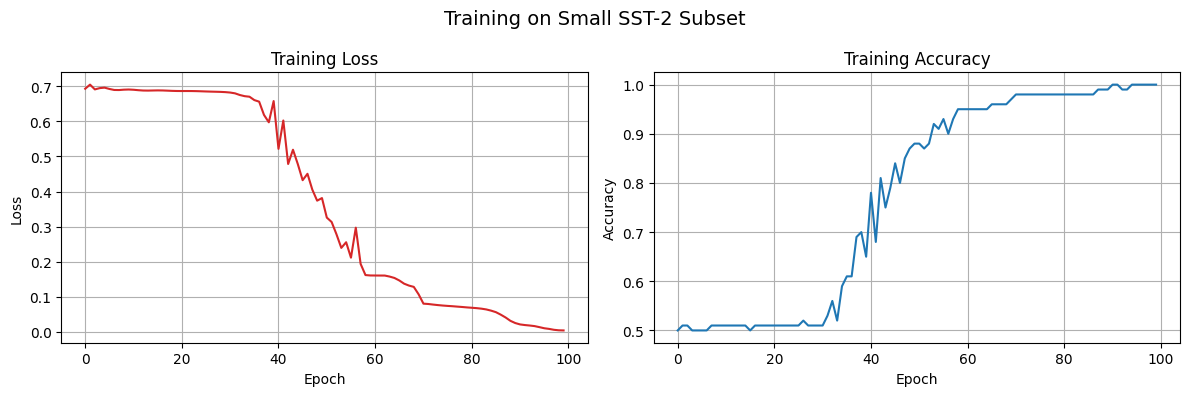

In [ ]:
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Loss
axes[0].plot(loss_history, color='tab:red')
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(acc_history, color='tab:blue')
axes[1].set_title("Training Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)

plt.suptitle("Training on Small SST-2 Subset", fontsize=14)
plt.tight_layout()
plt.show()

The plots show that the model initially struggles to learn, with loss and accuracy remaining flat for the first 30 epochs. Around epoch 30, both metrics improve significantly. The loss drops and accuracy rises sharply, indicating that the model begins learning effectively. By epoch 100, the model achieves a training accuracy of 1.0 and a low loss of 0.004, showing it successfully fits the training data. While overfitting is very likely due to the small dataset and naively good metrics, **the model clearly demonstrates the ability to learn**, although not to generalize.